In [1]:
!git clone https://github.com/Mukundanks/Comp-702.git

Cloning into 'Comp-702'...
remote: Enumerating objects: 5590, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 5590 (delta 2), reused 12 (delta 0), pack-reused 5562
Receiving objects: 100% (5590/5590), 1.06 GiB | 29.78 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil

import torch
import torchvision
from tqdm import tqdm

# import torch.optim as optim


In [3]:
!pip install torchsampler

In [4]:
!pip install pretrainedmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 668.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=ceeb6f1b2cac5ef18ce8c96e89e49030663ab5537340ce779fea95076a309c90
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels


In [5]:
# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import pandas as pd
import os
import matplotlib.image as mpimg

import torch
from PIL import Image, ImageFilter
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
from torchvision import transforms

import matplotlib.pyplot as plt

# %matplotlib inline

import warnings

warnings.filterwarnings("ignore")

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
# from keras.losses import binary_crossentropy
# from keras.applications.resnet import preprocess_input
# import keras.backend as K
# import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
# from keras.utils import Sequence
# from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import seaborn as sns


from torchsampler import ImbalancedDatasetSampler

WORKERS = 2
CHANNEL = 3

import warnings
import pretrainedmodels

warnings.filterwarnings("ignore")
IMG_SIZE = 512
NUM_CLASSES = 5
SEED = 77
TRAIN_NUM = (
    1000  # use 1000 when you just want to explore new idea, use -1 for full train
)

dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor

In [6]:
!pip install split-folders

In [7]:
!pip install pytest-shutil

In [8]:
img_dir = "../input/aptos2019-blindness-detection/train_images/"

In [9]:
data = pd.read_csv("../input/aptos2019-blindness-detection/train.csv")
data.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

<AxesSubplot:xlabel='diagnosis', ylabel='count'>

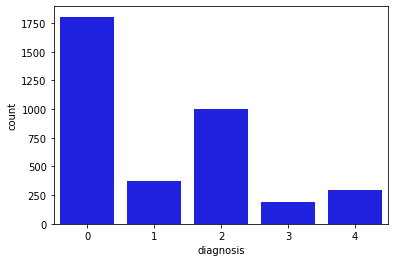

In [10]:
# Distribution of Training Data
display(data['diagnosis'].value_counts())
sns.countplot(data['diagnosis'], color='blue')

In [11]:
img_size = 300
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img
def preprocess_image(img_file):
    img = cv2.imread(img_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image_from_gray(img)
    img = cv2.resize(img, (img_size,img_size))
    return img

blur images

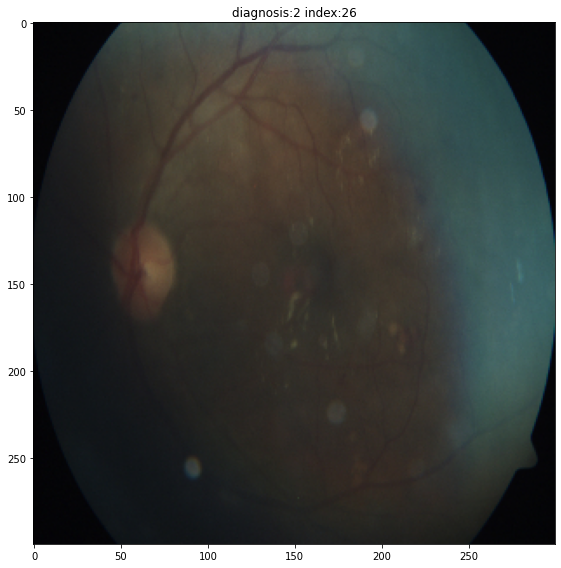

In [12]:
fig=plt.figure(figsize=(8, 8))
image_path = data.loc[8,'id_code']
image_id = data.loc[8,'diagnosis']
img =preprocess_image(f'../input/aptos2019-blindness-detection/train_images/{image_path}.png')
plt.title(f'diagnosis:{image_id} index:{26}')
plt.imshow(img)
plt.tight_layout()

dropping blurry images

In [13]:
def isClear(img, threshold = 60):
    return cv2.Laplacian(img, cv2.CV_64F).var() > threshold

finding blur images

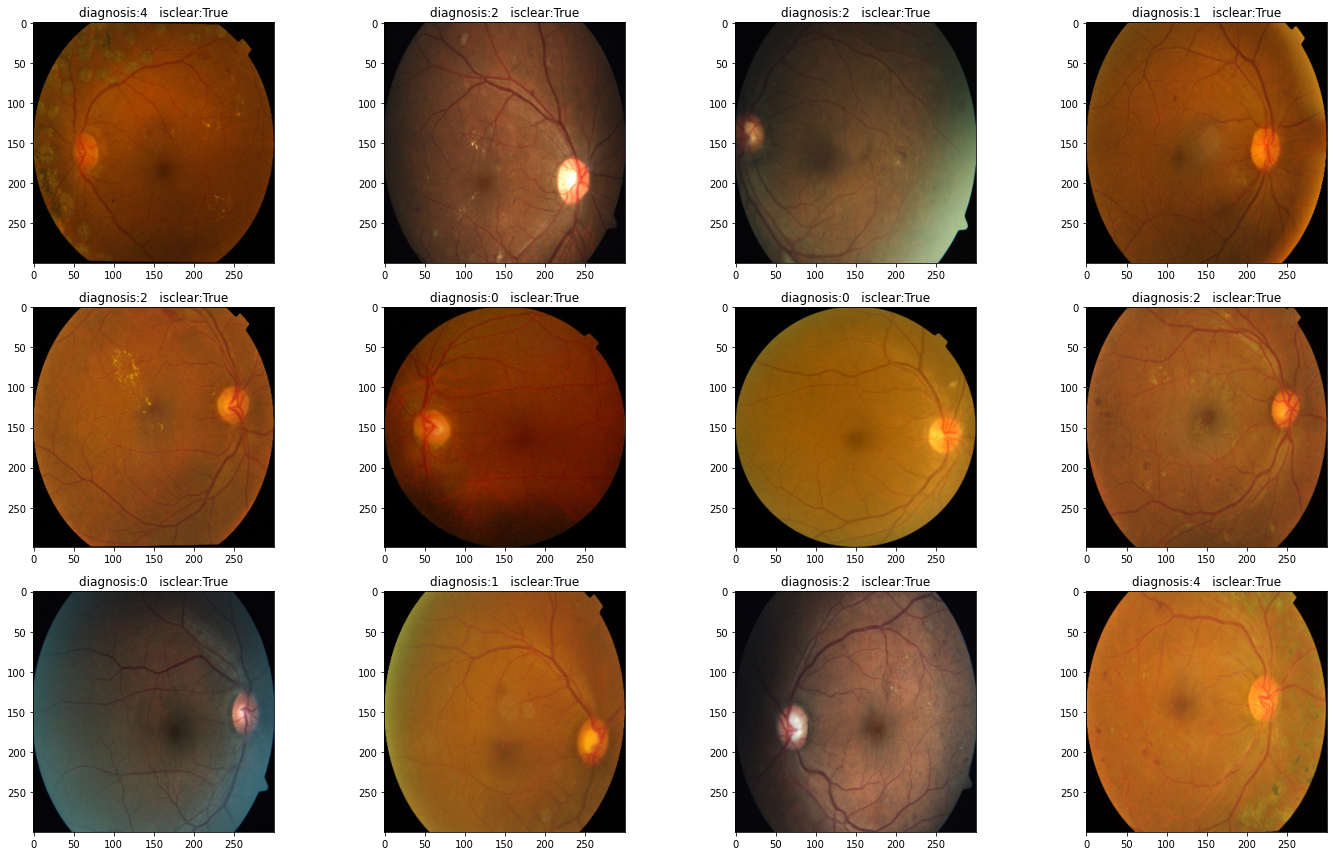

In [14]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))
    for i in range(columns*rows):
        idx = np.random.randint(0, len(df)-1, 1)[0]
        image_path = df.loc[idx,'id_code']
        image_id = df.loc[idx,'diagnosis']
        img = preprocess_image(f'../input/aptos2019-blindness-detection/train_images/{image_path}.png')
        fig.add_subplot(rows, columns, i+1)
        plt.title(f'diagnosis:{image_id}   isclear:{isClear(img)}')
        plt.imshow(img)
    plt.tight_layout()
display_samples(data)

dropping blur images

In [15]:
import time
blur_list = []
blur_list_id = []
start_time = time.time();
for i, image_id in enumerate(tqdm(data['id_code'])):
    img = preprocess_image(f'../input/aptos2019-blindness-detection/train_images/{image_id}.png')
    if(not isClear(img)):
        blur_list.append(i)
        blur_list_id.append(image_id)
data = data.drop(blur_list)
print(f'Cost: {time.time() - start_time}:.3% seconds');

100%|██████████| 3662/3662 [11:09<00:00,  5.47it/s]

Cost: 669.4329516887665:.3% seconds


see the number of dropped images

In [16]:
print(f'Droped items:{len(blur_list_id)}')


Droped items:175


displaying the dropped images

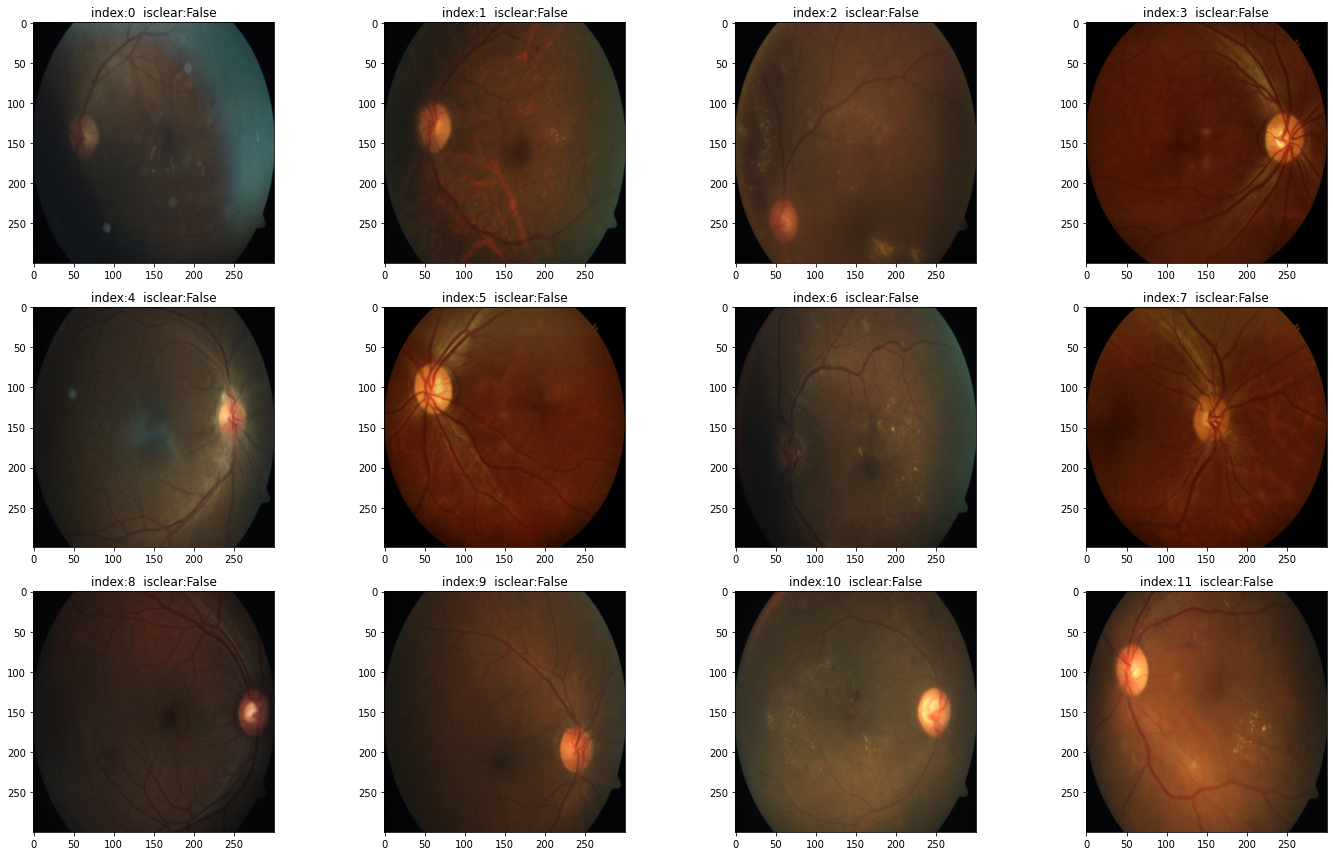

In [17]:
def display_blurry_samples(df, img_id_list, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))
    for i in range(columns*rows):
        img = preprocess_image(f'../input/aptos2019-blindness-detection/train_images/{img_id_list[i]}.png')
        fig.add_subplot(rows, columns, i+1)
        plt.title(f'index:{i}  isclear:{isClear(img)}')
        plt.imshow(img)
    plt.tight_layout()
display_blurry_samples(data, blur_list_id)

In [18]:
import os
len(os.listdir(f'../input/aptos2019-blindness-detection/train_images/'))

3662

In [19]:
data

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
...,...,...
3656,ff8a0b45c789,4
3657,ffa47f6a7bf4,2
3658,ffc04fed30e6,0
3659,ffcf7b45f213,2


In [20]:
no = data[data.diagnosis == 0]
mild = data[data.diagnosis == 1]
moderate = data[data.diagnosis == 2]
severe = data[data.diagnosis == 3]
dr = data[data.diagnosis == 4]

In [21]:
def seperation(data):
  file_path = []
  for f in range(len(data)):
      file = data.id_code.iloc[f]
      file = img_dir + file + '.png'
      file_path.append(file)
  return file_path

In [22]:
no = seperation(no)
mild = seperation(mild)
moderate = seperation(moderate)
severe = seperation(severe)
dr = seperation(dr)

In [23]:
len(no) + len(mild) + len(moderate) + len(severe) + len(dr) == len(data)

True

In [24]:
try:
    os.mkdir('train')
    os.mkdir("train/no")
    os.mkdir("train/mild")
    os.mkdir("train/moderate")
    os.mkdir("train/severe")
    os.mkdir("train/dr")
except:
    pass

In [25]:
def move(path, dst='train/no'):
  for old_path in path:
      name = old_path.split('/')
      name = name[-1]
      shutil.copy(old_path, f'{dst}/{name}')
move(no)
move(mild, dst='train/mild')
move(moderate, dst='train/moderate')
move(severe, dst='train/severe')
move(dr, dst='train/dr')

In [26]:
import splitfolders
# data_dir = '/content/train/'

splitfolders.ratio('./train/', output="output", seed=1337, ratio=(0.8, 0.0,0.2)) 


Copying files: 3487 files [01:05, 53.16 files/s]


In [27]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [28]:
def load_ben_color1(image, sigmaX=50):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted (image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

def circle_crop1(img, sigmaX=10):   
    """
    Create circular crop around image centre    
    """    
    
    
    image=load_ben_color1(img,sigmaX=50)
    
#     height, width, depth = img.shape    
    
#     x = int(width/2)
#     y = int(height/2)
#     r = np.amin((x,y))
    
#     circle_img = np.zeros((height, width), np.uint8)
#     cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
#     img = cv2.bitwise_and(img, img, mask=circle_img)
    #img = crop_image_from_gray(img)
#     img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img

In [29]:
!rm -r -f train

In [30]:
!mkdir preprocessed
!mkdir ./preprocessed/train
!mkdir ./preprocessed/train/no
!mkdir ./preprocessed/train/mild
!mkdir ./preprocessed/train/moderate
!mkdir ./preprocessed/train/dr
!mkdir ./preprocessed/train/severe

In [31]:
import os
from os import listdir
import shutil

list1=['dr', 'mild', 'moderate', 'no', 'severe']
for i in list1:
    folder_dir = "./output/train/"
    path1=os.path.join(folder_dir,i)
    for images in os.listdir(path1):
 
    # check if the image ends with png
        if (images.endswith(".png")):
            imagePath=os.path.join(path1,images)
            filename=images
#             print(imagePath)
            #img = cv2.imread(imagePath)
    
    
            image = cv2.imread(imagePath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # the trick is to add this line

    
    
    
    
    
            #image=circle_crop1(img)
            
            dest_dir= "./preprocessed/train/"
            path2=os.path.join(dest_dir,i,filename)
            
            #print(path2)
            cv2.imwrite(path2,image)
#             break
            #print(image)
            
            #result=PIL.Image.fromarray(image)
            #print(result)
            #result = PIL.Image.fromarray((image * 255).astype(numpy.uint8))
            #resultsave=result.save(filename)
            #print(resultsave)
            #picture = picture.save(filename) 
            #image_file=cv2.imwrite(image,filename)
            #shutil.copy(resultsave, path2)
            
                
                

                


Populating the interactive namespace from numpy and matplotlib


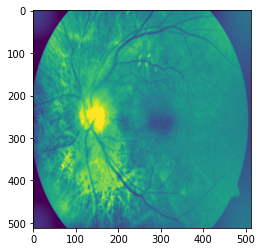

In [32]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(r'./preprocessed/train/mild/db4ed1e07aa3.png')
imgplot = plt.imshow(img)
plt.show()

In [33]:
# !mkdir preprocessed
!mkdir ./preprocessed/val
!mkdir ./preprocessed/val/no
!mkdir ./preprocessed/val/mild
!mkdir ./preprocessed/val/moderate
!mkdir ./preprocessed/val/dr
!mkdir ./preprocessed/val/severe

In [34]:
import os
from os import listdir
import shutil

list1=['dr', 'mild', 'moderate', 'no', 'severe']
for i in list1:
    folder_dir = "./output/val/"
    path1=os.path.join(folder_dir,i)
    for images in os.listdir(path1):
 
    # check if the image ends with png
        if (images.endswith(".png")):
            imagePath=os.path.join(path1,images)
            filename=images
#             print(imagePath)
            #img = cv2.imread(imagePath)
    
    
            image = cv2.imread(imagePath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # the trick is to add this line

    
    
    
    
    
            #image=circle_crop1(img)
            
            dest_dir= "./preprocessed/val/"
            path2=os.path.join(dest_dir,i,filename)
            
            #print(path2)
            cv2.imwrite(path2,image)
#             break
            #print(image)
            
            #result=PIL.Image.fromarray(image)
            #print(result)
            #result = PIL.Image.fromarray((image * 255).astype(numpy.uint8))
            #resultsave=result.save(filename)
            #print(resultsave)
            #picture = picture.save(filename) 
            #image_file=cv2.imwrite(image,filename)
            #shutil.copy(resultsave, path2)
            
                
                

                


In [35]:
# !mkdir preprocessed
!mkdir ./preprocessed/test
!mkdir ./preprocessed/test/no
!mkdir ./preprocessed/test/mild
!mkdir ./preprocessed/test/moderate
!mkdir ./preprocessed/test/dr
!mkdir ./preprocessed/test/severe

In [36]:
import os
from os import listdir
import shutil

list1=['dr', 'mild', 'moderate', 'no', 'severe']
for i in list1:
    folder_dir = "./output/test/"
    path1=os.path.join(folder_dir,i)
    for images in os.listdir(path1):
 
    # check if the image ends with png
        if (images.endswith(".png")):
            imagePath=os.path.join(path1,images)
            filename=images
#             print(imagePath)
            #img = cv2.imread(imagePath)
    
    
            image = cv2.imread(imagePath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # the trick is to add this line

    
    
    
    
    
            #image=circle_crop1(img)
            
            dest_dir= "./preprocessed/test/"
            path2=os.path.join(dest_dir,i,filename)
            
            #print(path2)
            cv2.imwrite(path2,image)
#             break
            #print(image)
            
            #result=PIL.Image.fromarray(image)
            #print(result)
            #result = PIL.Image.fromarray((image * 255).astype(numpy.uint8))
            #resultsave=result.save(filename)
            #print(resultsave)
            #picture = picture.save(filename) 
            #image_file=cv2.imwrite(image,filename)
            #shutil.copy(resultsave, path2)
            
                
                

                


In [37]:
train_dir = './preprocessed/train'
val_dir = './preprocessed/val'
test_dir = './preprocessed/test'

In [38]:
rm -r -f ./output

In [39]:
crop_size = 255
transformations = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize(crop_size),
        torchvision.transforms.CenterCrop(crop_size),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [40]:
batch_size = 4


In [41]:

train_data = torchvision.datasets.ImageFolder(root=train_dir, transform=transformations)
train_data = torch.utils.data.DataLoader(train_data, sampler=ImbalancedDatasetSampler(train_data),batch_size=batch_size,
                                          shuffle=False, num_workers=2)
# valid_data = torchvision.datasets.ImageFolder(root=val_dir, transform=transformations)
# valid_data = torch.utils.data.DataLoader(valid_data, shuffle=True, batch_size=batch_size)

test_data = torchvision.datasets.ImageFolder(root=test_dir, 
                                        transform=transformations)
test_data = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

classes = ('0','1','2','3','4')

In [42]:
test_data.dataset.classes

['dr', 'mild', 'moderate', 'no', 'severe']

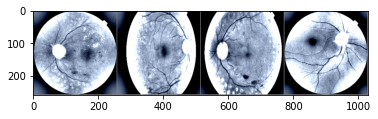

0     2     4     3    


In [43]:

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_data)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [44]:
device = ['cuda','cpu']

pre-trained models

In [45]:
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


available parameters in a model


In [46]:
# print(pretrainedmodels.pretrained_settings['resnet34'])

In [47]:
# model = 'resnet34'

In [48]:
# model = pretrainedmodels.__dict__[model](num_classes=1000, pretrained='imagenet')

In [49]:
model = torchvision.models.resnet50(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [50]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [51]:
model.fc = nn.Linear(2048,5)

In [52]:
device = 'cuda'

In [53]:
model = model.to(device)

In [54]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [55]:
loss_l = []
acc_l = []
accuracy = 0
best_accuracy = 0
running_loss = 0.0
print(len(test_data))
for epoch in range(35):
  with tqdm(train_data, unit="iteration") as train_epoch:
    train_epoch.set_description(f"Epoch {epoch}")
    for step, data in enumerate(train_epoch):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
#         if i % 733 == 732:    # print every 2000 mini-batches
#             print(f'[{epoch + 1}] loss: {running_loss / 10:.3f}')
        running_loss = 0.0
        outputs = torch.argmax(outputs, 1)
        accuracy = (outputs == labels).float().mean()
        train_epoch.set_postfix(loss=loss.item(), accuracy=100*accuracy.item())
        
#         acc_l.append(accuracy.item())
#         loss_l.append(loss.item())
        
#         if accuracy < best_accuracy:
#             torch.save(model, f'model_resnet.pth')
#             best_accuracy = accuracy 
            
            
            
    running_vloss = 0.0

#     model.train(False) # Don't need to track gradents for validation
#     for j, vdata in enumerate(valid_data, 0):
#         vinputs, vlabels = vdata
#         vinputs, vlabels = vinputs.to(device), vlabels.to(device)
#         voutputs = model(vinputs)
#         vloss = loss_fn(voutputs, vlabels)
#         running_vloss += vloss.item()
#     model.train(True) # Turn gradients back on for training

#     avg_loss = running_loss / 1000
#     avg_vloss = running_vloss / len(valid_data)

print('Finished Training')

torch.save(model, f'model_resnet.pth')

175


Epoch 34: 100%|██████████| 697/697 [00:44<00:00, 15.57iteration/s, accuracy=100, loss=0.000693]


Finished Training


In [56]:
# PATH = './resnetpy.pth'
# torch.save(model.state_dict(), PATH)
# torch.save(model, 'resnetpy.pth')

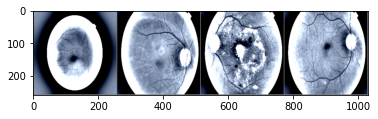

GroundTruth:  3     1     2     1    


In [57]:
dataiter = iter(test_data)
images, labels = next(dataiter)
# images, labels = images.to(device), labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [58]:
len(images)

4

In [59]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [60]:
# len(model.classes)

In [61]:
# # net = model()
# modelp = model.load_state_dict(torch.load('./resnetpy.pth'))
# # modelp
modelp = torch.load('./model_resnet.pth')
modelp = modelp.to(device)

In [62]:
images, labels = images.to(device), labels.to(device)

outputs = modelp(images)

In [63]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  3     1     2     1    


In [64]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_data:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = modelp(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10 test images: {100 * correct // total} %')

Accuracy of the network on the 10 test images: 79 %


In [65]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_data:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = modelp(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 61.4 %
Accuracy for class: 1     is 76.1 %
Accuracy for class: 2     is 68.1 %
Accuracy for class: 3     is 96.0 %
Accuracy for class: 4     is 35.1 %


In [66]:
!pip install torch torchvision matplotlib tensorboard



In [67]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
# writer = SummaryWriter('runs/resnet1')

In [68]:
# # get some random training images
# dataiter = iter(train_data)
# images, labels = next(dataiter)

# # create grid of images
# img_grid = torchvision.utils.make_grid(images)

# # show images
# matplotlib_imshow(img_grid, one_channel=True)

# # write to tensorboard
# writer.add_image('5 classes', img_grid)

In [69]:
# %load_ext tensorboard
# %tensorboard --logdir logs
# %reload_ext tensorboard

In [70]:
# !tensorboard --logdir=runs

In [71]:
# writer.add_graph(modelp, images)
# writer.close()

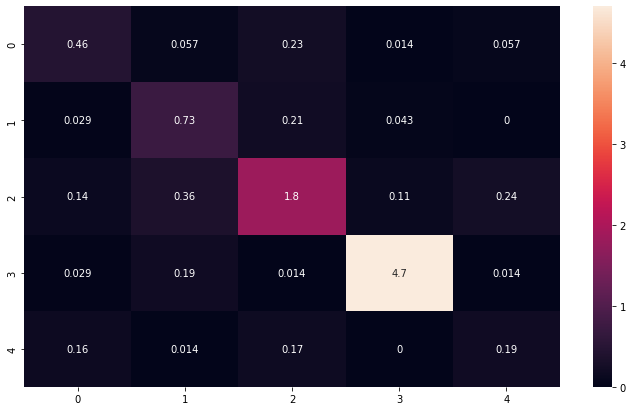

In [72]:
##confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []
modelp = modelp.to('cpu')

# iterate over test data
for inputs, labels in test_data:
        inputs = inputs
        labels = labels
        output = modelp(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0','1','2','3','4')
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')
